# Library and Basic setting

In [1]:
import numpy as np

import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl

# default setting
np.set_printoptions(precision=2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

In [2]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=135,
                    help='size of mini batch')
parser.add_argument('--learning_rate', type=float, default=0.0008, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--is_normalization', type=bool,
                    default=True, help='whether do data normalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int,
                    help='Input images will be resized to this for data argumentation.')
parser.add_argument('--model_dir', type=str,
                    default='/notebooks/global_localization/lightning/baseline', help='rnn, gru, or lstm')
parser.add_argument('--test_dataset', type=str, default=['/notebooks/michigan_nn_data/2012_02_12',
                                                         '/notebooks/michigan_nn_data/2012_04_29',
                                                         '/notebooks/michigan_nn_data/2012_05_11',
                                                         '/notebooks/michigan_nn_data/2012_06_15',
                                                         '/notebooks/michigan_nn_data/2012_08_04',
                                                         '/notebooks/michigan_nn_data/2012_10_28',
                                                         '/notebooks/michigan_nn_data/2012_11_16',
                                                         '/notebooks/michigan_nn_data/2012_12_01'])
parser.add_argument('--train_dataset', type=str, default=['/notebooks/michigan_nn_data/2012_01_08',
                                                          '/notebooks/michigan_nn_data/2012_01_15',
                                                          '/notebooks/michigan_nn_data/2012_01_22',
                                                          '/notebooks/michigan_nn_data/2012_02_02',
                                                          '/notebooks/michigan_nn_data/2012_02_04',
                                                          '/notebooks/michigan_nn_data/2012_02_05',
                                                          '/notebooks/michigan_nn_data/2012_03_31',
                                                          '/notebooks/michigan_nn_data/2012_09_28'])
parser.add_argument('--norm_tensor', type=str,
                    default=['/notebooks/global_localization/norm_mean_std.pt'])

sys.argv = ['']
args = parser.parse_args()

# Load Dataset

In [ ]:
import torchvision.transforms as transforms
import os
import sys
sys.path.append('..')
from torchlib.utils import LocalizationDataset
from torch.utils.data import DataLoader

[args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = LocalizationDataset(dataset_dirs = args.test_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, 
                              get_pair = False, mode='evaluate', sampling_rate=2)

test_loader = DataLoader(test_dataset, batch_size=args.batch_size, \
                        shuffle=False, num_workers=os.cpu_count(), drop_last=False)

  3%|▎         | 442/14835 [00:00<00:19, 738.25it/s]

In [ ]:
#from torch.cuda.amp import autocast, GradScaler
import gpytorch
import sys
sys.path.append('..')
from torchlib.GPs import Backbone, NN
from torchlib.cnn_auxiliary import normalize, denormalize_navie


# Gaussian Process Model
class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([1])),
            batch_shape=torch.Size([1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class Baseline(pl.LightningModule):

    def __init__(self):
        super().__init__()
        # parameters
        inducing_points = torch.zeros(3, 300, 128)
        self.backbone = Backbone()
        self.nn = NN()
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
            num_tasks=3)
        [norm_mean, norm_std] = torch.load(*args.norm_tensor)
        self.norm_mean = torch.nn.parameter.Parameter(norm_mean,requires_grad=False)
        self.norm_std = torch.nn.parameter.Parameter(norm_std,requires_grad=False) 
        
        # shut down backbone learning
        self._disable_grad(self.backbone)

    def forward(self, x):
        dense_feat = self.backbone(x)
        output, feature_t, feature_r = self.nn(dense_feat)
        _, rot_pred = torch.split(output, [3, 4], dim=1)
        trans_pred = self.gp(feature_t)
        return trans_pred, rot_pred

    def training_step(self, batch, batch_idx):
        x, y = batch.values()
        y = normalize(y, self.norm_mean, self.norm_std)
        train_loss,trans_loss,rot_loss = self.__loss(x, y)
        #self.log('train_loss', train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        tensorboard = self.logger.experiment
        #tensorboard.add_scalar('train_loss',float(train_loss),self.global_step)
        tensorboard.add_scalars('train_loss',
                                {'total_loss':float(train_loss),
                                'trans_loss':float(trans_loss),
                                'rot_loss':float(rot_loss)},
                                self.global_step)
        return train_loss

    def __loss(self, x, y):
        # target
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        # predict
        trans_pred, rot_pred = self.forward(x)

        # trans loss
        mll = gpytorch.mlls.PredictiveLogLikelihood(self.likelihood, self.gp, num_data=num_data)
        trans_loss = -1.*mll(trans_pred, trans_target)
        # rot loss
        rot_loss = 1. - \
            torch.mean(torch.square(
                torch.sum(torch.mul(rot_pred, rot_target), dim=1)))

        total_loss = trans_loss + args.lamda_weights * rot_loss

        return total_loss, trans_loss, rot_loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch.values()
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_pred, rot_pred = self.forward(x)
        
        trans_pred, trans_mean, trans_var = self._eval_gp(trans_pred)
        trans_pred = denormalize_navie(trans_pred, self.norm_mean, self.norm_std)
        trans_mean = denormalize_navie(trans_mean, self.norm_mean, self.norm_std)
        trans_var = trans_var.mul(self.norm_std)
        samples = self._sample(trans_mean, trans_var, 100)
        
        trans_loss = torch.sqrt(torch.sum((trans_pred - trans_target)**2,dim=1)).mean()
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        #return trans_pred, rot_pred, trans_target, rot_target, samples
        
        val_loss = trans_loss
        self.log('val_loss', val_loss, on_step=True, on_epoch=True, prog_bar=False, logger=False)
        tensorboard = self.logger.experiment
        tensorboard.add_scalars('val_loss',
                                {'trans_loss':float(trans_loss),
                                'rot_loss':float(rot_loss)},
                                self.current_epoch*self.trainer.num_val_batches[0]+batch_idx)
        return val_loss
    
    def _eval_gp(self, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = self.likelihood(trans_pred).mean, self.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = torch.distributions.Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples
    
    def eval_forward(self,x,y):
        x, y = x.to(self.device),y.to(self.device)
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_pred, rot_pred = self.forward(x)
        
        trans_pred, trans_mean, trans_var = self._eval_gp(trans_pred)
        trans_pred = denormalize_navie(trans_pred, self.norm_mean, self.norm_std)
        trans_mean = denormalize_navie(trans_mean, self.norm_mean, self.norm_std)
        trans_var = trans_var.mul(self.norm_std)
        samples = self._sample(trans_mean, trans_var, 100)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples
        
    def configure_optimizers(self):
        lr,weight_decay = args.learning_rate,args.weight_decay
        optimizer_args = [
            {'params': self.gp.parameters(), 'lr': lr, 'weight_decay': weight_decay},
            {'params': self.likelihood.parameters(), 'lr': lr,
             'weight_decay': weight_decay},
            {'params': self.nn.global_regressor.parameters(), 'lr': lr * 0.01,
             'weight_decay': weight_decay},
            {'params': self.nn.global_context.parameters(), 'lr': lr * 0.001, 'weight_decay': weight_decay}]
        
        optimizer = torch.optim.Adam(optimizer_args)

        return optimizer
    
    def show_require_grad(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                print (name, param.shape)
                
    def _disable_grad(self,model):
        for param in model.parameters():
            param.requires_grad = False
            
    def get_progress_bar_dict(self):
        tqdm_dict = super().get_progress_bar_dict()
        if 'v_num' in tqdm_dict:
            del tqdm_dict['v_num']
        return tqdm_dict
    
    def train_dataloader(self):
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=True, num_workers=os.cpu_count(),drop_last=True)
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size,
                                shuffle=False, num_workers=os.cpu_count(),drop_last=True)
        return val_loader
    
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint


#trainer = pl.Trainer(gpus=1,precision=32)
model = Baseline.load_from_checkpoint(os.path.join(args.model_dir,'pretrained-model-epoch=52-val_loss=0.23.ckpt'))
#trainer.fit(model)

# Initialize

In [ ]:
trans_errors = []
rot_errors = []
uncertainties = []
pose_map = []

total_trans_error = 0.
total_rot_error = 0.

count = 0.

is_save_map = False
is_read_map = False

trans_preds = []
trans_gts = []

rot_preds = []
rot_gts = []

pred_uncertainties = []

pred_time = []

In [6]:
import math

model._disable_grad(model)
model.eval()
model.gp.eval()
model.likelihood.eval()
model.cuda()

for b, data in enumerate(test_loader, 0):
    start = time.time()
    
    x,y = data.values()
    x = x.cuda()
    y = y.cuda()
    trans_pred, rot_pred, trans_gt, rot_gt, samples = model.eval_forward(x,y)
    
    # transform data
    trans_pred = trans_pred.cpu().numpy()
    rot_pred = rot_pred.cpu().numpy()
    trans_gt = trans_gt.cpu().numpy()
    rot_gt = rot_gt.cpu().numpy()
    
    end = time.time()
    
    count += y.shape[0]
    
    trans_preds += [x for x in trans_pred]
    rot_preds += [x for x in rot_pred]
    trans_gts += [x for x in trans_gt]
    rot_gts += [x for x in rot_gt]

    trans_error = np.sqrt(np.sum((trans_pred - trans_gt)**2,axis=1))
    rot_error_1 = np.arccos(np.sum(np.multiply(rot_pred,rot_gt),axis=1))/math.pi*180
    rot_error_2 = np.arccos(np.sum(np.multiply(rot_pred,-rot_gt),axis=1))/math.pi*180
    rot_error = np.minimum(rot_error_1,rot_error_2)

    trans_errors += [x for x in trans_error]
    rot_errors += [x for x in rot_error]

    total_trans_error += np.sum(trans_error)
    total_rot_error += np.sum(rot_error)
    
    display = 1

    if b % display == 0:
        print(
            "{}/{}, translation error = {:.3f}, rotation error = {:.3f}, time/batch = {:.3f}"
            .format(
             (b+1)*args.batch_size,
            len(test_loader)*args.batch_size,
            total_trans_error / count,
            total_rot_error / count,
            end - start))

135/92070, translation error = 2.871, rotation error = 1.664, time/batch = 3.857
270/92070, translation error = 2.599, rotation error = 2.030, time/batch = 0.817
405/92070, translation error = 7.214, rotation error = 2.741, time/batch = 1.214
540/92070, translation error = 6.619, rotation error = 3.005, time/batch = 1.269
675/92070, translation error = 5.742, rotation error = 2.819, time/batch = 1.086
810/92070, translation error = 5.337, rotation error = 2.709, time/batch = 1.254
945/92070, translation error = 6.592, rotation error = 2.829, time/batch = 1.060
1080/92070, translation error = 6.236, rotation error = 3.198, time/batch = 1.088
1215/92070, translation error = 6.418, rotation error = 3.318, time/batch = 1.171
1350/92070, translation error = 6.168, rotation error = 3.540, time/batch = 0.951
1485/92070, translation error = 5.806, rotation error = 3.533, time/batch = 1.022
1620/92070, translation error = 5.473, rotation error = 3.667, time/batch = 0.989
1755/92070, translation

13635/92070, translation error = 4.108, rotation error = 3.558, time/batch = 0.884
13770/92070, translation error = 4.091, rotation error = 3.572, time/batch = 0.994
13905/92070, translation error = 4.075, rotation error = 3.568, time/batch = 1.059
14040/92070, translation error = 4.054, rotation error = 3.560, time/batch = 1.194
14175/92070, translation error = 4.029, rotation error = 3.550, time/batch = 0.852
14310/92070, translation error = 4.021, rotation error = 3.571, time/batch = 0.912
14445/92070, translation error = 4.000, rotation error = 3.557, time/batch = 1.059
14580/92070, translation error = 3.979, rotation error = 3.535, time/batch = 1.361
14715/92070, translation error = 3.964, rotation error = 3.532, time/batch = 0.878
14850/92070, translation error = 3.966, rotation error = 3.543, time/batch = 1.030
14985/92070, translation error = 3.950, rotation error = 3.541, time/batch = 1.000
15120/92070, translation error = 3.937, rotation error = 3.537, time/batch = 1.255
1525

27000/92070, translation error = 8.301, rotation error = 4.485, time/batch = 0.979
27135/92070, translation error = 8.267, rotation error = 4.470, time/batch = 0.967
27270/92070, translation error = 8.240, rotation error = 4.459, time/batch = 0.991
27405/92070, translation error = 8.214, rotation error = 4.446, time/batch = 1.016
27540/92070, translation error = 8.189, rotation error = 4.434, time/batch = 1.182
27675/92070, translation error = 8.160, rotation error = 4.422, time/batch = 0.852
27810/92070, translation error = 8.134, rotation error = 4.409, time/batch = 0.911
27945/92070, translation error = 8.104, rotation error = 4.411, time/batch = 0.984
28080/92070, translation error = 8.077, rotation error = 4.401, time/batch = 0.982
28215/92070, translation error = 8.050, rotation error = 4.389, time/batch = 1.129
28350/92070, translation error = 8.032, rotation error = 4.395, time/batch = 0.854
28485/92070, translation error = 8.007, rotation error = 4.387, time/batch = 0.959
2862

40365/92070, translation error = 8.746, rotation error = 4.669, time/batch = 1.219
40500/92070, translation error = 8.723, rotation error = 4.662, time/batch = 0.909
40635/92070, translation error = 8.697, rotation error = 4.659, time/batch = 1.011
40770/92070, translation error = 8.675, rotation error = 4.657, time/batch = 1.001
40905/92070, translation error = 8.650, rotation error = 4.662, time/batch = 1.109
41040/92070, translation error = 8.630, rotation error = 4.656, time/batch = 0.959
41175/92070, translation error = 8.607, rotation error = 4.654, time/batch = 1.085
41310/92070, translation error = 8.585, rotation error = 4.651, time/batch = 0.883
41445/92070, translation error = 8.562, rotation error = 4.641, time/batch = 1.011
41580/92070, translation error = 8.541, rotation error = 4.639, time/batch = 1.083
41715/92070, translation error = 8.518, rotation error = 4.638, time/batch = 0.860
41850/92070, translation error = 8.495, rotation error = 4.633, time/batch = 0.887
4198

53730/92070, translation error = 8.364, rotation error = 4.636, time/batch = 1.607
53865/92070, translation error = 8.346, rotation error = 4.637, time/batch = 0.880
54000/92070, translation error = 8.329, rotation error = 4.635, time/batch = 0.866
54135/92070, translation error = 8.312, rotation error = 4.632, time/batch = 1.041
54270/92070, translation error = 8.400, rotation error = 4.649, time/batch = 1.359
54405/92070, translation error = 8.389, rotation error = 4.647, time/batch = 0.918
54540/92070, translation error = 8.377, rotation error = 4.642, time/batch = 1.060
54675/92070, translation error = 8.360, rotation error = 4.637, time/batch = 1.199
54810/92070, translation error = 8.343, rotation error = 4.636, time/batch = 1.082
54945/92070, translation error = 8.331, rotation error = 4.634, time/batch = 1.398
55080/92070, translation error = 8.314, rotation error = 4.628, time/batch = 0.867
55215/92070, translation error = 8.297, rotation error = 4.627, time/batch = 0.940
5535

67095/92070, translation error = 9.533, rotation error = 5.171, time/batch = 0.873
67230/92070, translation error = 9.532, rotation error = 5.182, time/batch = 0.960
67365/92070, translation error = 9.520, rotation error = 5.202, time/batch = 0.959
67500/92070, translation error = 9.514, rotation error = 5.208, time/batch = 0.943
67635/92070, translation error = 9.498, rotation error = 5.205, time/batch = 0.982
67770/92070, translation error = 9.483, rotation error = 5.198, time/batch = 1.119
67905/92070, translation error = 9.468, rotation error = 5.192, time/batch = 0.782
68040/92070, translation error = 9.452, rotation error = 5.185, time/batch = 0.861
68175/92070, translation error = 9.438, rotation error = 5.179, time/batch = 0.959
68310/92070, translation error = 9.424, rotation error = 5.181, time/batch = 0.892
68445/92070, translation error = 9.411, rotation error = 5.183, time/batch = 0.891
68580/92070, translation error = 9.398, rotation error = 5.180, time/batch = 0.974
6871

80460/92070, translation error = 10.563, rotation error = 5.686, time/batch = 1.065
80595/92070, translation error = 10.661, rotation error = 5.737, time/batch = 0.866
80730/92070, translation error = 10.658, rotation error = 5.751, time/batch = 0.916
80865/92070, translation error = 10.647, rotation error = 5.745, time/batch = 1.016
81000/92070, translation error = 10.634, rotation error = 5.744, time/batch = 1.085
81135/92070, translation error = 10.640, rotation error = 5.746, time/batch = 0.895
81270/92070, translation error = 10.659, rotation error = 5.778, time/batch = 1.021
81405/92070, translation error = 10.712, rotation error = 5.792, time/batch = 1.122
81540/92070, translation error = 10.702, rotation error = 5.805, time/batch = 0.864
81675/92070, translation error = 10.690, rotation error = 5.803, time/batch = 0.985
81810/92070, translation error = 10.677, rotation error = 5.802, time/batch = 0.919
81945/92070, translation error = 10.670, rotation error = 5.804, time/batch 

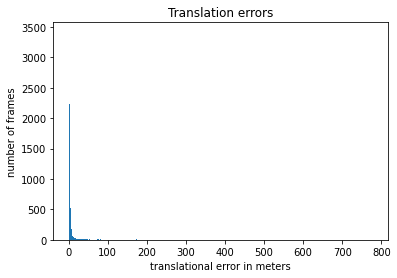

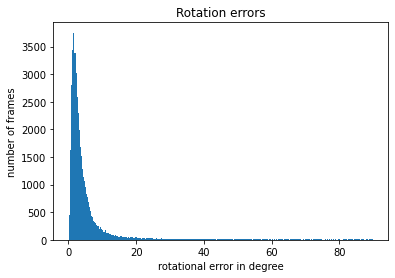

median translation error = 2.003
median rotation error = 2.798
mean translation error = 10.576
mean rotation error = 6.036


In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(trans_errors, bins='auto')
plt.title("Translation errors")
plt.xlabel("translational error in meters")
plt.ylabel("number of frames")
#plt.savefig('terror.png', bbox_inches='tight')
plt.show()

plt.hist(rot_errors, bins='auto')
plt.title("Rotation errors")
plt.xlabel("rotational error in degree")
plt.ylabel("number of frames")
#plt.savefig('rerror.png', bbox_inches='tight')
plt.show()

median_trans_errors = np.median(trans_errors)
median_rot_errors = np.median(rot_errors)
mean_trans_errors = np.mean(trans_errors)
mean_rot_errors = np.mean(rot_errors)

print("median translation error = {:.3f}".format(median_trans_errors))
print("median rotation error = {:.3f}".format(median_rot_errors))
print("mean translation error = {:.3f}".format(mean_trans_errors))
print("mean rotation error = {:.3f}".format(mean_rot_errors))   

In [8]:
def evaluate(trans_errors,rot_errors):
    t = test_dataset.last_indexes
    trans_errors_month = list()
    trans_errors_month.append(trans_errors[:t[0]])
    trans_errors_month.append(trans_errors[t[0]:t[1]])
    trans_errors_month.append(trans_errors[t[1]:t[2]])
    trans_errors_month.append(trans_errors[t[2]:t[3]])
    trans_errors_month.append(trans_errors[t[3]:t[4]])
    trans_errors_month.append(trans_errors[t[4]:t[5]])
    trans_errors_month.append(trans_errors[t[5]:t[6]])
    trans_errors_month.append(trans_errors[t[6]:])

    rot_errors_month = list()
    rot_errors_month.append(rot_errors[:t[0]])
    rot_errors_month.append(rot_errors[t[0]:t[1]])
    rot_errors_month.append(rot_errors[t[1]:t[2]])
    rot_errors_month.append(rot_errors[t[2]:t[3]])
    rot_errors_month.append(rot_errors[t[3]:t[4]])
    rot_errors_month.append(rot_errors[t[4]:t[5]])
    rot_errors_month.append(rot_errors[t[5]:t[6]])
    rot_errors_month.append(rot_errors[t[6]:])
    
    print('================== median translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("median translation error = {:.3f}".format(np.median(trans_errors_i)))
        
    print('================== median rotation error ==================')
    for rot_errors_i in rot_errors_month:
        print("median rotation error = {:.3f}".format(np.median(rot_errors_i)))
    
    print('================== mean translation error ==================')
    for trans_errors_i in trans_errors_month:
        print("mean translation error = {:.3f}".format(np.mean(trans_errors_i)))
        
    print('================== mean rotation error ==================')  
    for rot_errors_i in rot_errors_month:
        print("mean rotation error = {:.3f}".format(np.mean(rot_errors_i)))
        
evaluate(trans_errors,rot_errors)

================== median translation error ==================
median translation error = 1.544
median translation error = 1.639
median translation error = 1.890
median translation error = 1.893
median translation error = 1.963
median translation error = 2.061
median translation error = 3.367
median translation error = 2.691
================== median rotation error ==================
median rotation error = 2.387
median rotation error = 2.550
median rotation error = 2.631
median rotation error = 2.550
median rotation error = 2.840
median rotation error = 2.841
median rotation error = 3.883
median rotation error = 3.623
================== mean translation error ==================
mean translation error = 4.020
mean translation error = 4.265
mean translation error = 12.427
mean translation error = 12.399
mean translation error = 9.272
mean translation error = 11.190
mean translation error = 20.268
mean translation error = 13.450
================== mean rotation error ==================
m